In [19]:
import pandas as pd
import numpy as np  


In [20]:
num_samples = 10

random_state = 16

num_of_ratios = 5

Load the metadata file. We index it by sample_id, but keep this column as well as a feature

In [21]:
metadata = pd.read_csv("../Data/metadata.csv").set_index('sample_id',drop = False)

metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1494 entries, S0000 to S1505
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sample_id          1494 non-null   object
 1   split              1494 non-null   object
 2   instrument_type    1494 non-null   object
 3   features_path      1494 non-null   object
 4   features_md5_hash  1494 non-null   object
dtypes: object(5)
memory usage: 70.0+ KB


In [22]:
metadata.head()

,sample_id,split,instrument_type,features_path,features_md5_hash
sample_id,,,,,
S0000,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
S0001,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
S0002,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
S0003,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
S0004,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


We complete the paths in the "features_path" column so that we can read the corresponding csv files more easily.

In [23]:
def replace_value (x):
    return x.replace(" ","")

new_path = "../Data/"

def fix_path(incomplete_path):
    return new_path + incomplete_path

metadata.features_path = metadata['features_path'].apply(replace_value)
metadata.features_path = metadata['features_path'].apply(fix_path)

metadata.head()

,sample_id,split,instrument_type,features_path,features_md5_hash
sample_id,,,,,
S0000,S0000,train,commercial,../Data/train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
S0001,S0001,train,commercial,../Data/train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
S0002,S0002,train,commercial,../Data/train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
S0003,S0003,train,commercial,../Data/train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
S0004,S0004,train,commercial,../Data/train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78


Check what proportion of samples in the metadata file are associated with commercial vs SAM instruments

In [24]:
metadata.instrument_type.value_counts(normalize=True)

instrument_type
commercial    1.0
Name: proportion, dtype: float64

Turns out they are all commercial. Now store the various paths to csv folders into dictionaries, depending on whether the samples are in the train, val or test set. We do not have access to any test_files, so those can probably be disregarded. After this point, metadata will not be used again


In [25]:
train_files = metadata[metadata.split == "train"]["features_path"].to_dict()
val_files = metadata[metadata.split == 'val']["features_path"].to_dict()
test_files = metadata[metadata.split == 'test']["features_path"].to_dict()

# creates a dictionary that contains a path for each sample

In [26]:
train_labels = pd.read_csv("../Data/train_labels.csv",index_col="sample_id")

train_labels.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0


We can see what proportion of the labels contains each ion

In [27]:
for column_name in train_labels.columns:
    print(train_labels[column_name].value_counts(normalize=True))

basalt
0    0.87931
1    0.12069
Name: proportion, dtype: float64
carbonate
0    0.871353
1    0.128647
Name: proportion, dtype: float64
chloride
0    0.876658
1    0.123342
Name: proportion, dtype: float64
iron_oxide
0    0.775862
1    0.224138
Name: proportion, dtype: float64
oxalate
0    0.960212
1    0.039788
Name: proportion, dtype: float64
oxychlorine
0    0.762599
1    0.237401
Name: proportion, dtype: float64
phyllosilicate
0    0.679045
1    0.320955
Name: proportion, dtype: float64
silicate
0    0.862069
1    0.137931
Name: proportion, dtype: float64
sulfate
0    0.803714
1    0.196286
Name: proportion, dtype: float64
sulfide
0    0.952255
1    0.047745
Name: proportion, dtype: float64


Print the ions in descending order of frequency:

In [28]:
sums_normalized = train_labels.aggregate("sum").sort_values(ascending = False)

print(sums_normalized.index.values)


['phyllosilicate' 'oxychlorine' 'iron_oxide' 'sulfate' 'silicate'
 'carbonate' 'chloride' 'basalt' 'sulfide' 'oxalate']


Now put them in a bar plot

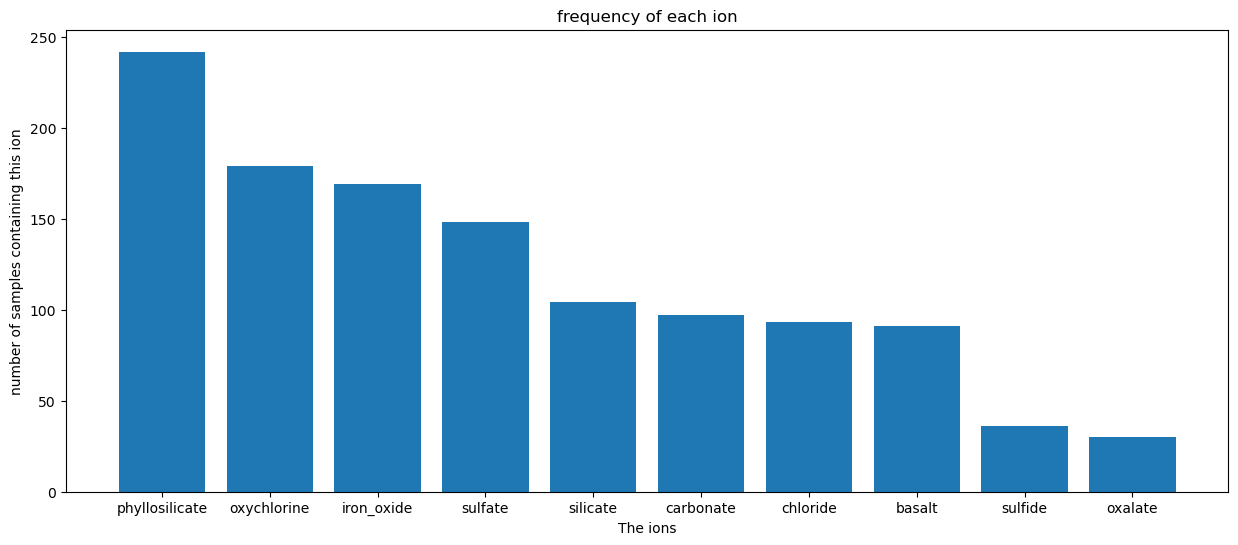

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

plt.bar( sums_normalized.index.values, sums_normalized.values)

plt.title('frequency of each ion')

plt.xlabel("The ions")

plt.ylabel("number of samples containing this ion")

plt.show()



For a collection of samples we plot temperature as a function of time.

In [30]:


from random import sample 

samples_list = sample(list(train_files.keys()),25)

num_samples = len(samples_list)

num_samples


25

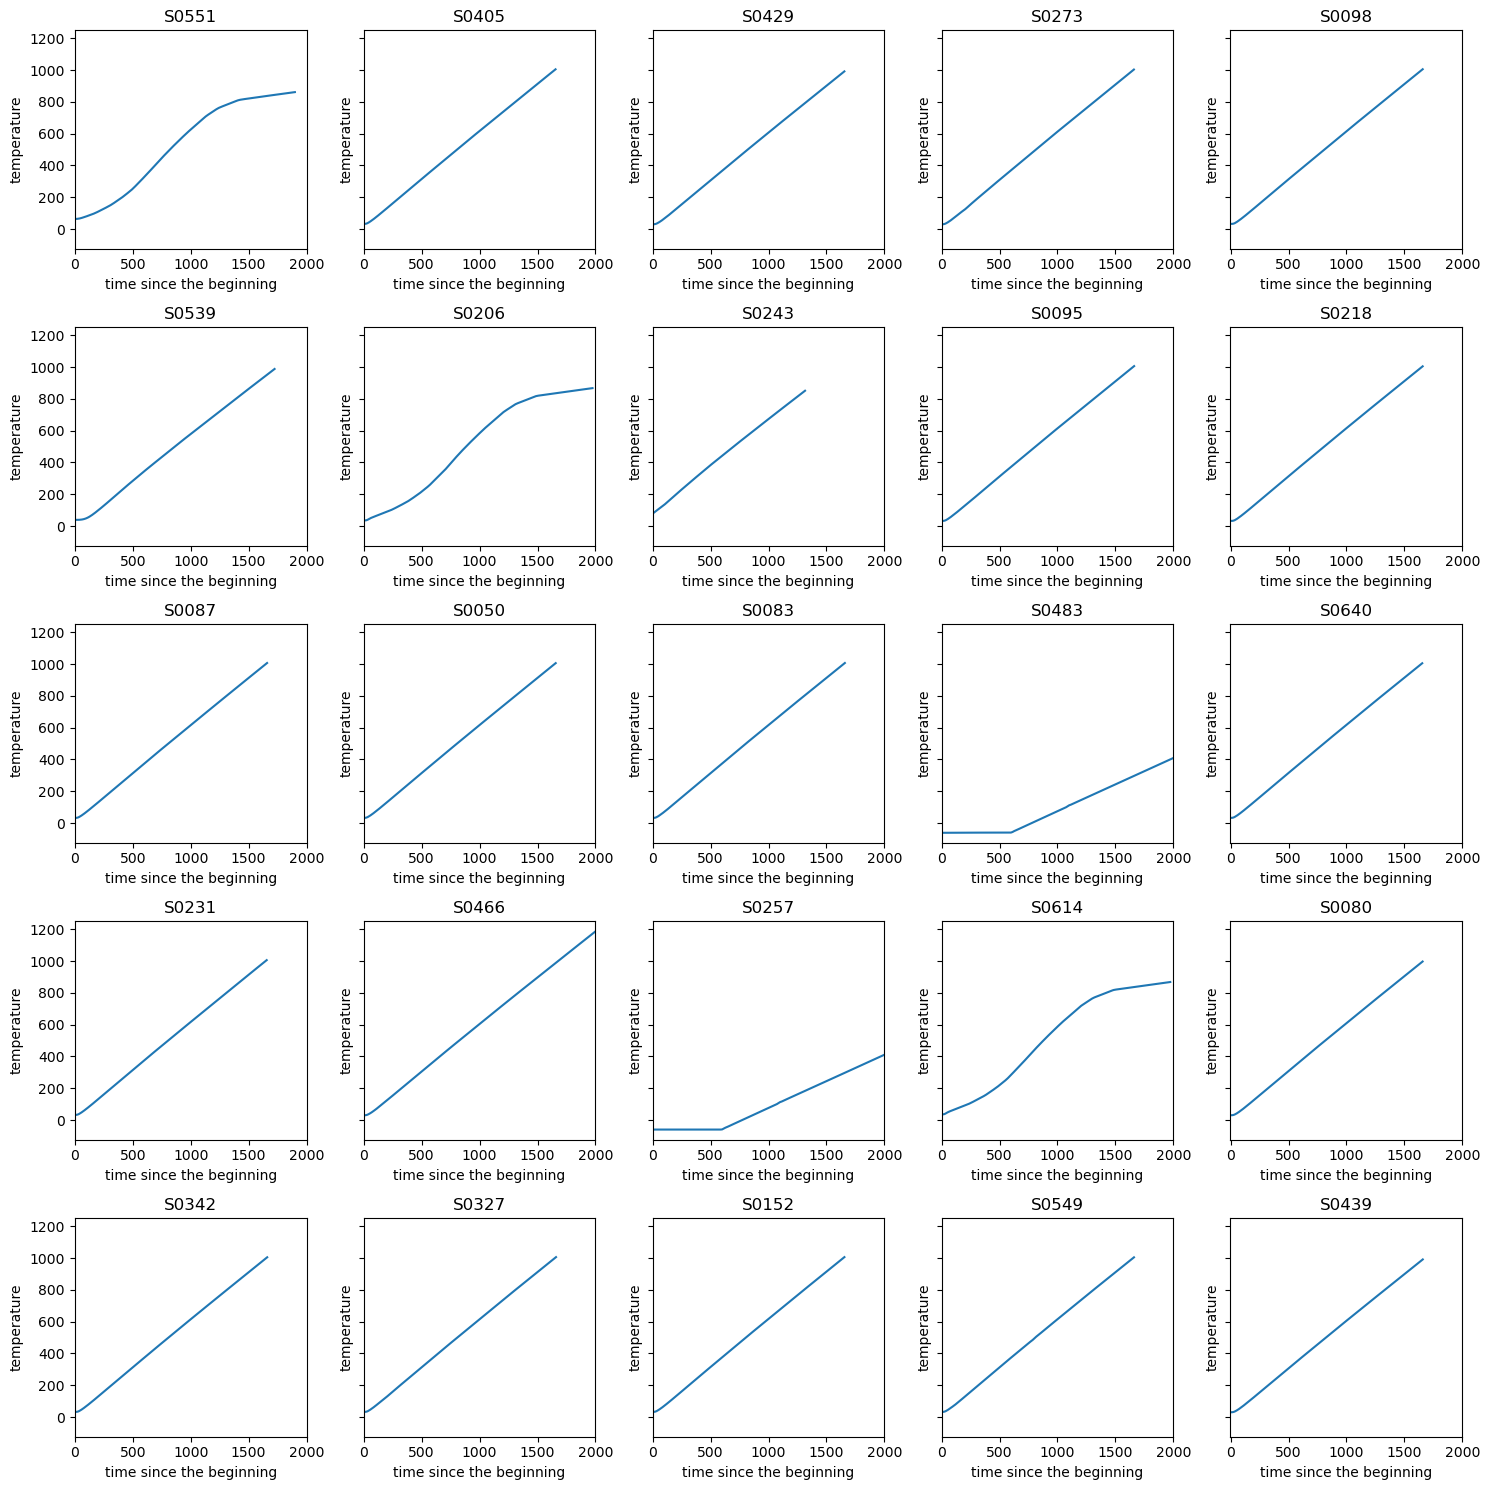

In [31]:
# Create a figure and an array of subplots indexed using axis

fig, ax = plt.subplots(nrows=5,ncols=5,sharey = True,figsize = (15,15))


for i, sample in enumerate(samples_list): 

    df = pd.read_csv(train_files[sample])

    plt.subplot(5,5,i+1)

    plt.plot(df.time,df.temp)
    
    plt.xlim((-1,2000))
    plt.ylim = ((-100,1600))


    
    plt.xlabel('time since the beginning')
    
    plt.ylabel('temperature')
    
    plt.title(sample)



# fig.set_size_inches(14,10)



fig.tight_layout()

plt.show()



One can see the plots corresponding to various samples by running all cells above.

Now we plot the various ions grouped by m/z, on a logarithmic scale.

/var/folders/sb/bm5l_dgs6vg61tdy4phf0vcm0000gn/T/ipykernel_8056/733269853.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


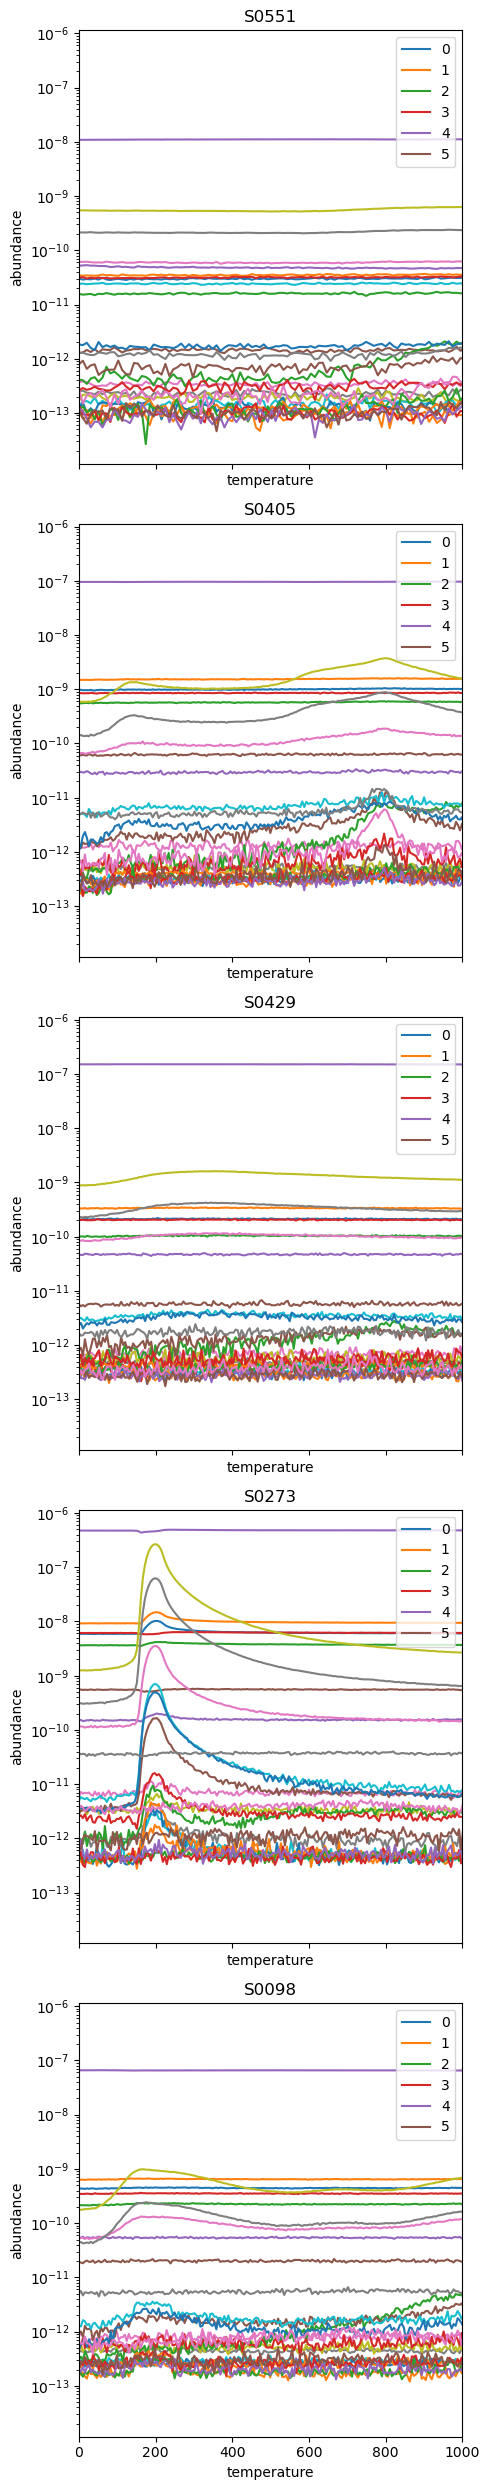

In [32]:
num_samples = 5

fig, ax = plt.subplots(num_samples,1,sharex = True,sharey = True,figsize = (5,5*num_samples))


for i, sample in enumerate(samples_list[:num_samples]):

    df = pd.read_csv(train_files[sample])
    

    plt.subplot(num_samples,1,i+1)

    

    for mz in range(0,28):
        X = df[df['m/z'] == mz].time
        y = df[df['m/z'] == mz].abundance

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz<=5:
            plt.plot(X,y,label = str(mz))
        else:
            plt.plot(X,y,label = "")

        
        

        plt.xlabel('temperature')
        plt.ylabel('abundance')
        plt.xlim(0,1000)
        
        # ax[i] = plt.show()
    
    plt.legend()


    
    plt.yscale('log')
    plt.title(sample)
    
    del df


fig.tight_layout()     
    
fig.show()






## Preprocessing the data

We do the data cleaning suggested by the post. Note that the part about removing non-integer values of m/z is probably not relevant to us, it seems that it only applies to SAM samples, which we do not have access to.

In [33]:
def drop_non_int_and_He(df):
    df2 = df
    df2 = df2[df2['m/z'].transform(round) == df2['m/z']]
    df2 = df2[df2['m/z']<100]
    df2 = df2[df2['m/z'] != 4]
    return df2

In [34]:
def subtract_min(df):    

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )


    return df


The next function scales the abundances by the formula $\frac{x-x_{\mathrm{min}}}{x_{max}-x_{min}}$ and forces them to be in the range (0,1)

In [35]:
from sklearn.preprocessing import minmax_scale

def scale_to_zero_one(df):
    df['zero_one_rescale'] = minmax_scale(df['abundance_minsub'])
    assert (df['zero_one_rescale'].max()<=1)
    return df
    


The following combines the procedures above

In [36]:
def preprocess(df):
    return scale_to_zero_one(subtract_min(drop_non_int_and_He(df)))

We need to consider the temperature at which the ions come out and look at the relative ratio of the area under the curves at each temperature range.

The following creates a dictionary containing all train files. By changing the sample_list variable, one can make a dictionary with only a subset of them

In [37]:
from random import sample

samples_list = list(train_files.keys())
print (len(samples_list))

754


In [38]:
# Define temp bins
temp_bin = pd.interval_range(start=-100, end=1500, freq=100)

# Make list to store temp bin labels
index_list = []
for temp in temp_bin:
    index_list.append(str(temp))

x_min = -100
x_max = 1500

num_bins = 16
bin_width = (x_max - x_min) / num_bins

# make a dictionary to store dataframes with area data

DictAreas = {}

# samples_areas = np.zeros(len(samples_list))

# Import trapezoid rule to integrate under curve
from scipy.integrate import simpson, trapezoid

for i, sample in enumerate(samples_list):

    
    # print (np.shape(areas))
    df = pd.read_csv(train_files[sample]) # read the sample file

    df_mod = preprocess(df)

    areas = np.zeros((num_bins, 100)) 

    

  
    for mz in range(100):

        df_mz = df_mod[df_mod['m/z'] == mz]

        for j in range(num_bins):
            x_left = x_min + j * bin_width
            x_right = x_left + bin_width
            
            # Make x array by getting values in dataframe between x_left and x_right
            x_array = np.array(df_mz[df_mz['temp'].between(x_left, x_right, inclusive='right')]['temp'])
            y_array = np.array(df_mz[df_mz['temp'].between(x_left, x_right, inclusive='right')]['zero_one_rescale'])

            # Add calculated area to areas array
            areas[j,mz] = trapezoid(y_array, x_array)

        
    # Make dataframe out of areas array and set the index to the temp bins
    areas_df = pd.DataFrame(areas)
    areas_df.index = index_list 

    DictAreas[sample] = areas_df
         
    

In [127]:
import pickle

with open('DictAreas.pickle', 'wb') as f:
    pickle.dump(DictAreas, f)

In [22]:
DictAreas['S0594']

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
"(-100, 0]",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(0, 100]",0.418650,0.867240,0.538298,0.575043,0.0,0.100948,0.010072,0.002300,0.008071,0.002236,...,0.001846,0.001471,0.002422,0.001509,0.001822,0.001718,0.001625,0.002017,0.001989,0.002081
"(100, 200]",0.939043,1.743427,1.126114,1.019774,0.0,0.156880,0.018277,0.003190,0.008952,0.003118,...,0.002738,0.002325,0.002883,0.002134,0.002547,0.002654,0.002339,0.003363,0.003130,0.002942
"(200, 300]",0.937592,1.601362,1.115314,1.123474,0.0,0.164563,0.016778,0.003386,0.010681,0.002698,...,0.002905,0.002382,0.003052,0.002033,0.002278,0.002805,0.002358,0.002941,0.002903,0.002946
"(300, 400]",0.901050,1.666068,1.015783,1.004739,0.0,0.167867,0.014635,0.004232,0.011048,0.003347,...,0.002779,0.002268,0.003320,0.002485,0.002923,0.002789,0.002471,0.003125,0.002996,0.003135
"(400, 500]",0.842569,1.521168,0.908920,0.926821,0.0,0.171556,0.016509,0.004058,0.009483,0.002754,...,0.002693,0.002342,0.003006,0.002185,0.002317,0.002689,0.002425,0.002958,0.002539,0.002971
"(500, 600]",0.821153,1.459174,0.840101,0.952066,0.0,0.166585,0.015437,0.002928,0.011121,0.003649,...,0.002707,0.002251,0.003114,0.002192,0.002195,0.002394,0.002493,0.002956,0.003152,0.002997
"(600, 700]",1.267724,1.879882,0.737528,0.902149,0.0,0.149645,0.016187,0.003860,0.012879,0.003652,...,0.002954,0.002426,0.003143,0.002175,0.002723,0.002543,0.002476,0.003776,0.002833,0.002853
"(700, 800]",1.170468,1.758543,0.867302,0.786895,0.0,0.173408,0.017025,0.004029,0.012113,0.003162,...,0.003103,0.002426,0.002959,0.002312,0.002461,0.002904,0.002399,0.002933,0.002927,0.003010
"(800, 900]",1.700917,2.344523,1.346423,0.686337,0.0,0.168769,0.017330,0.003935,0.012849,0.003288,...,0.002641,0.002344,0.003050,0.002261,0.002390,0.002414,0.002582,0.002976,0.002845,0.003061


#### Plots of the areas under rescaled abundance curves, split by temperature bin.

In [45]:
from random import sample
samples_list = sample(list(train_files.keys()),10)

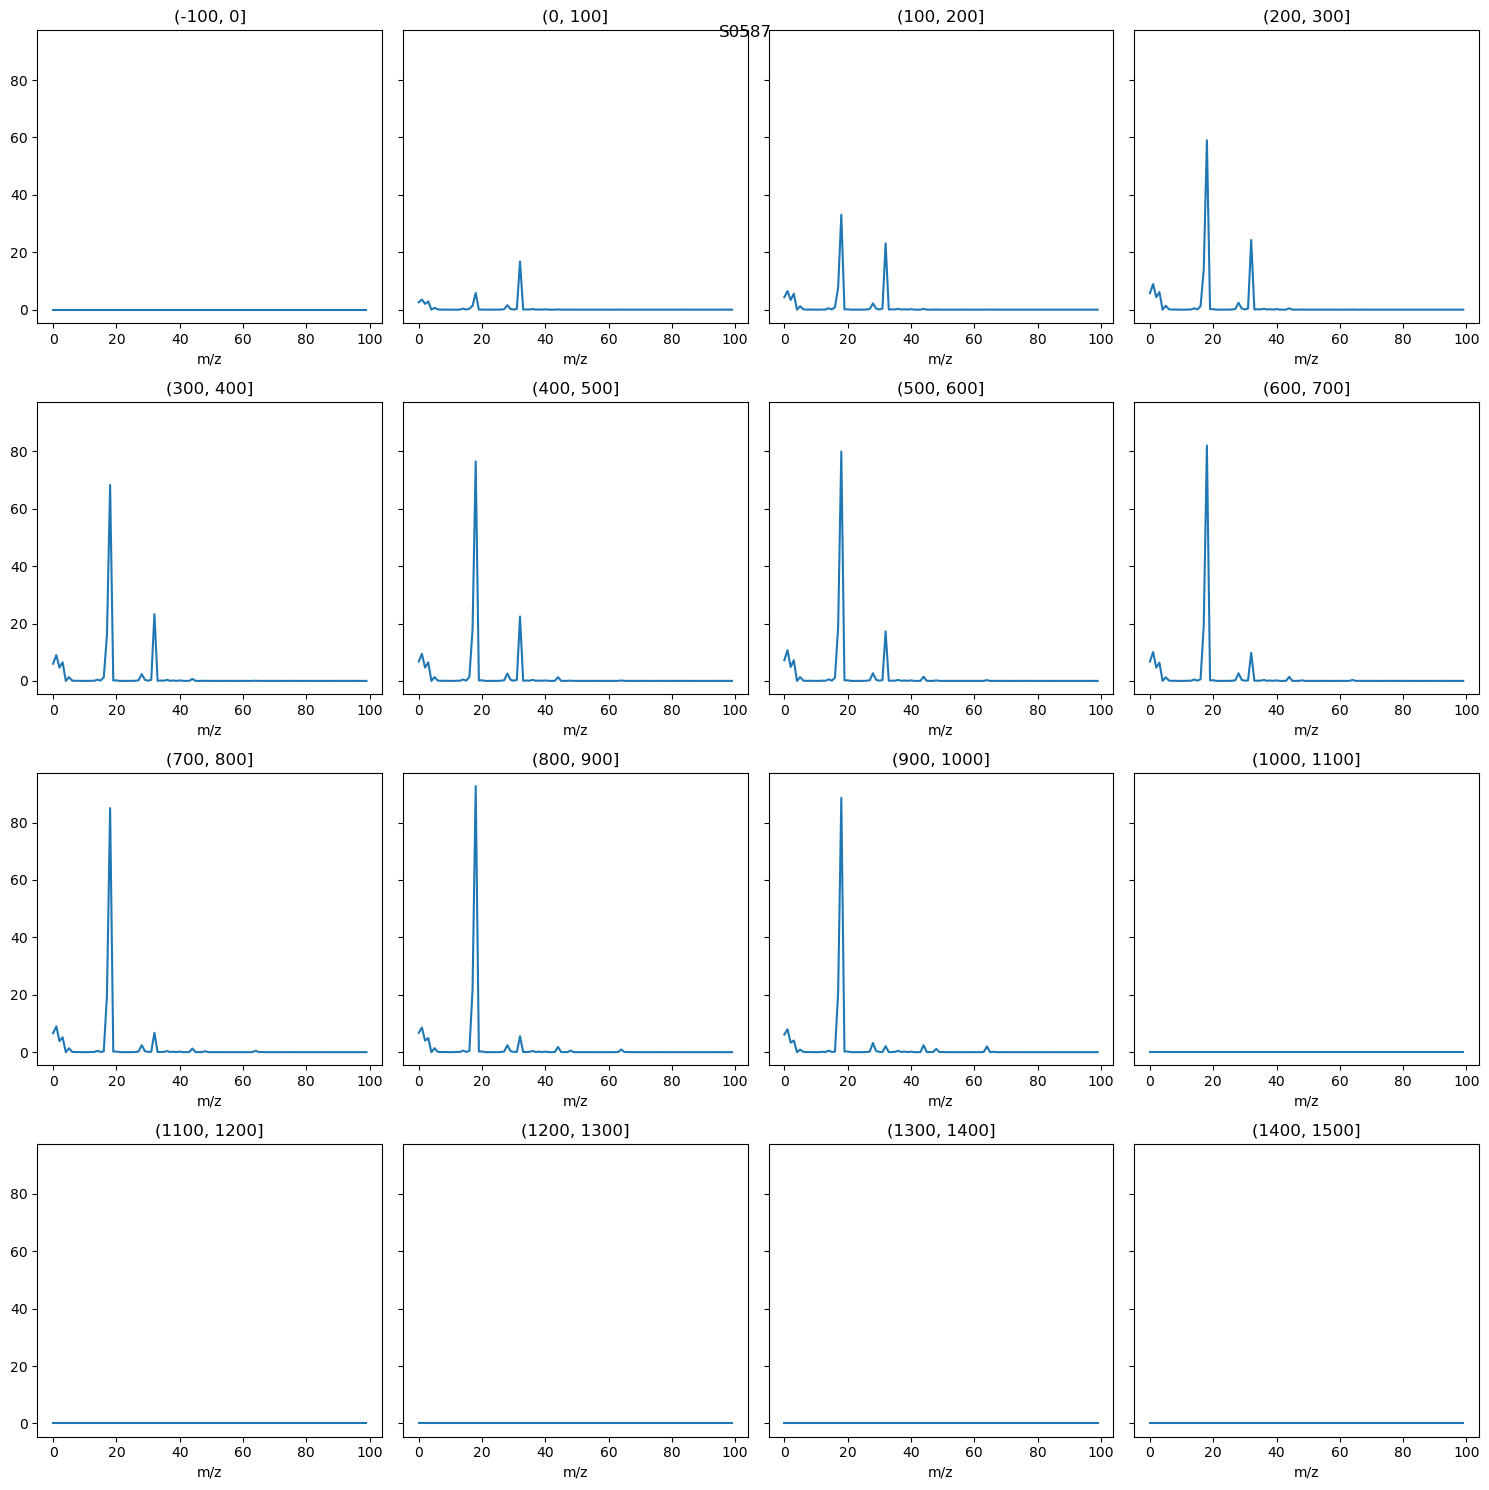

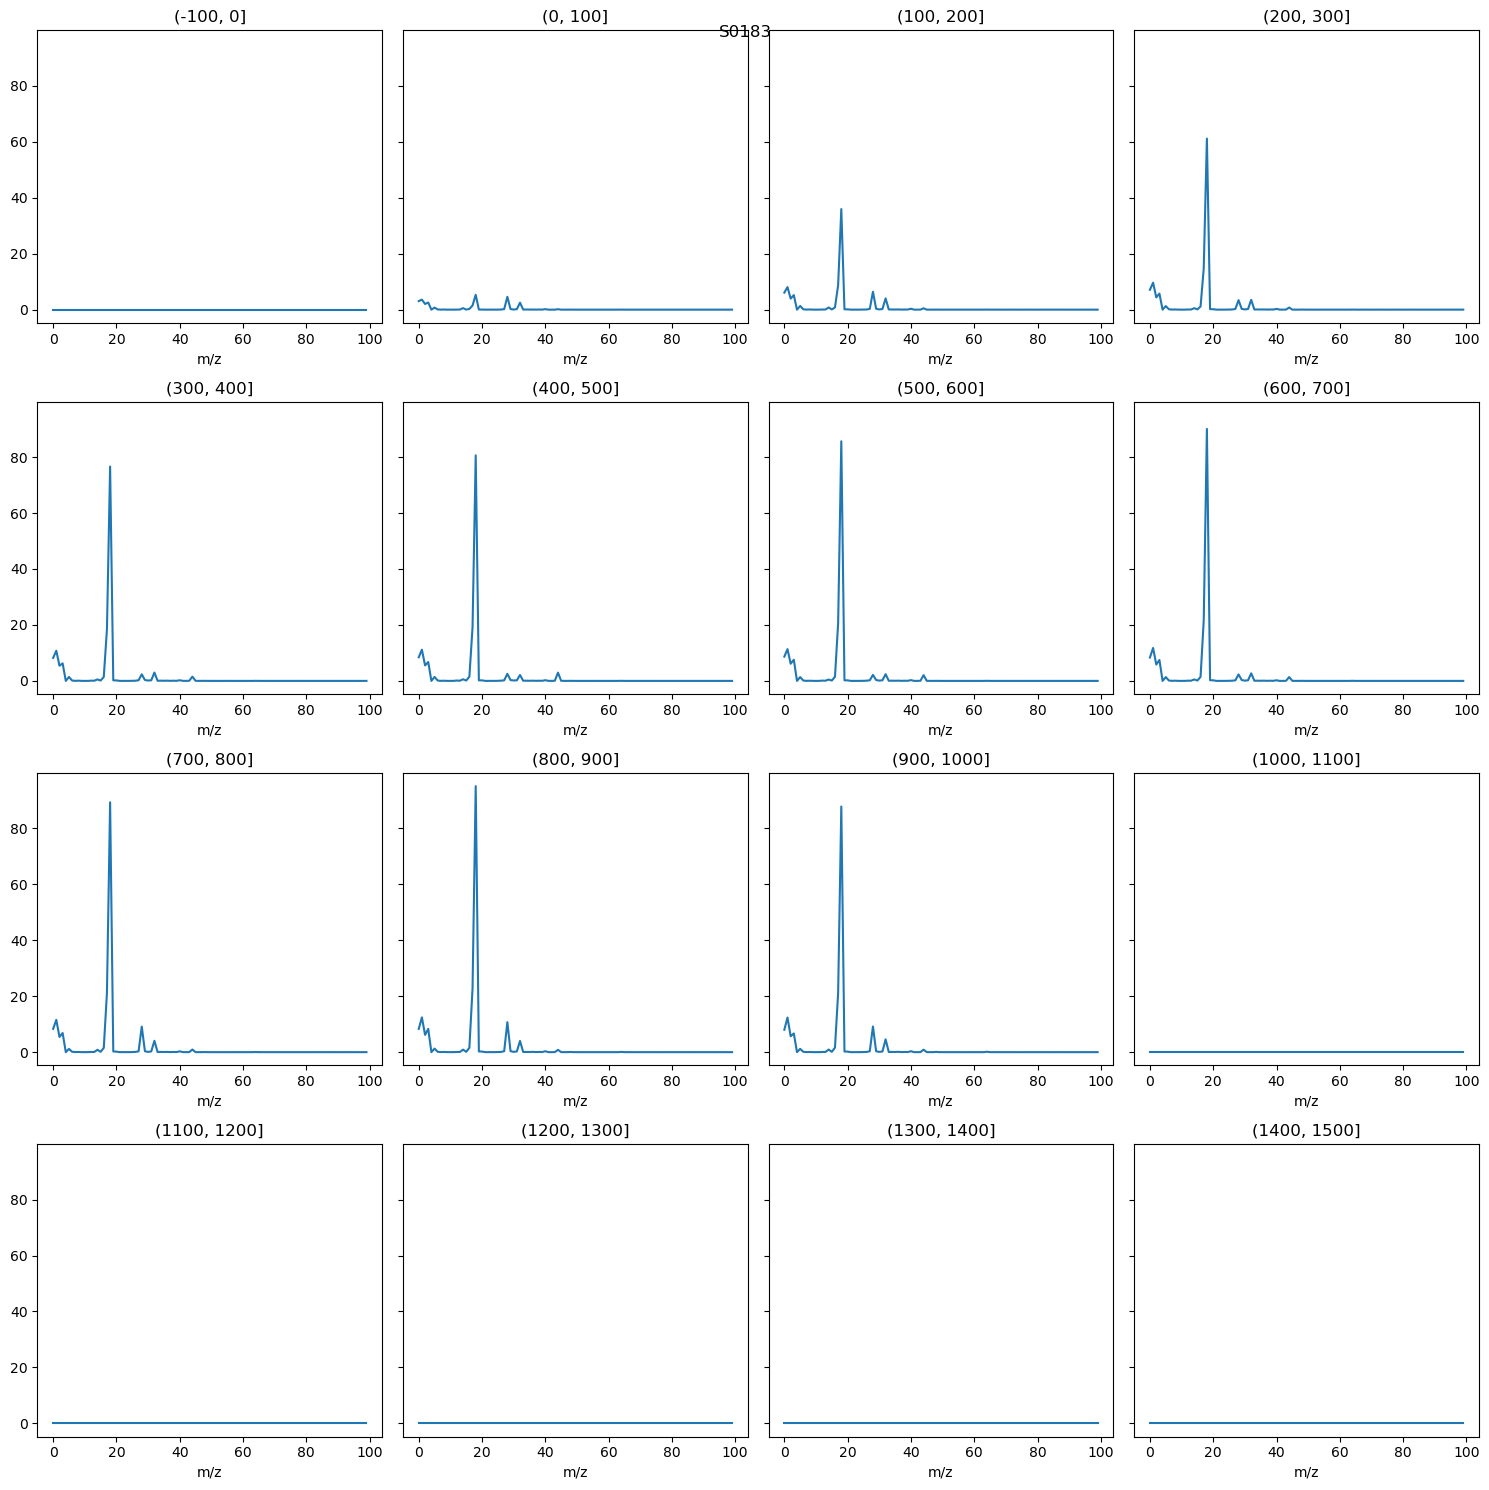

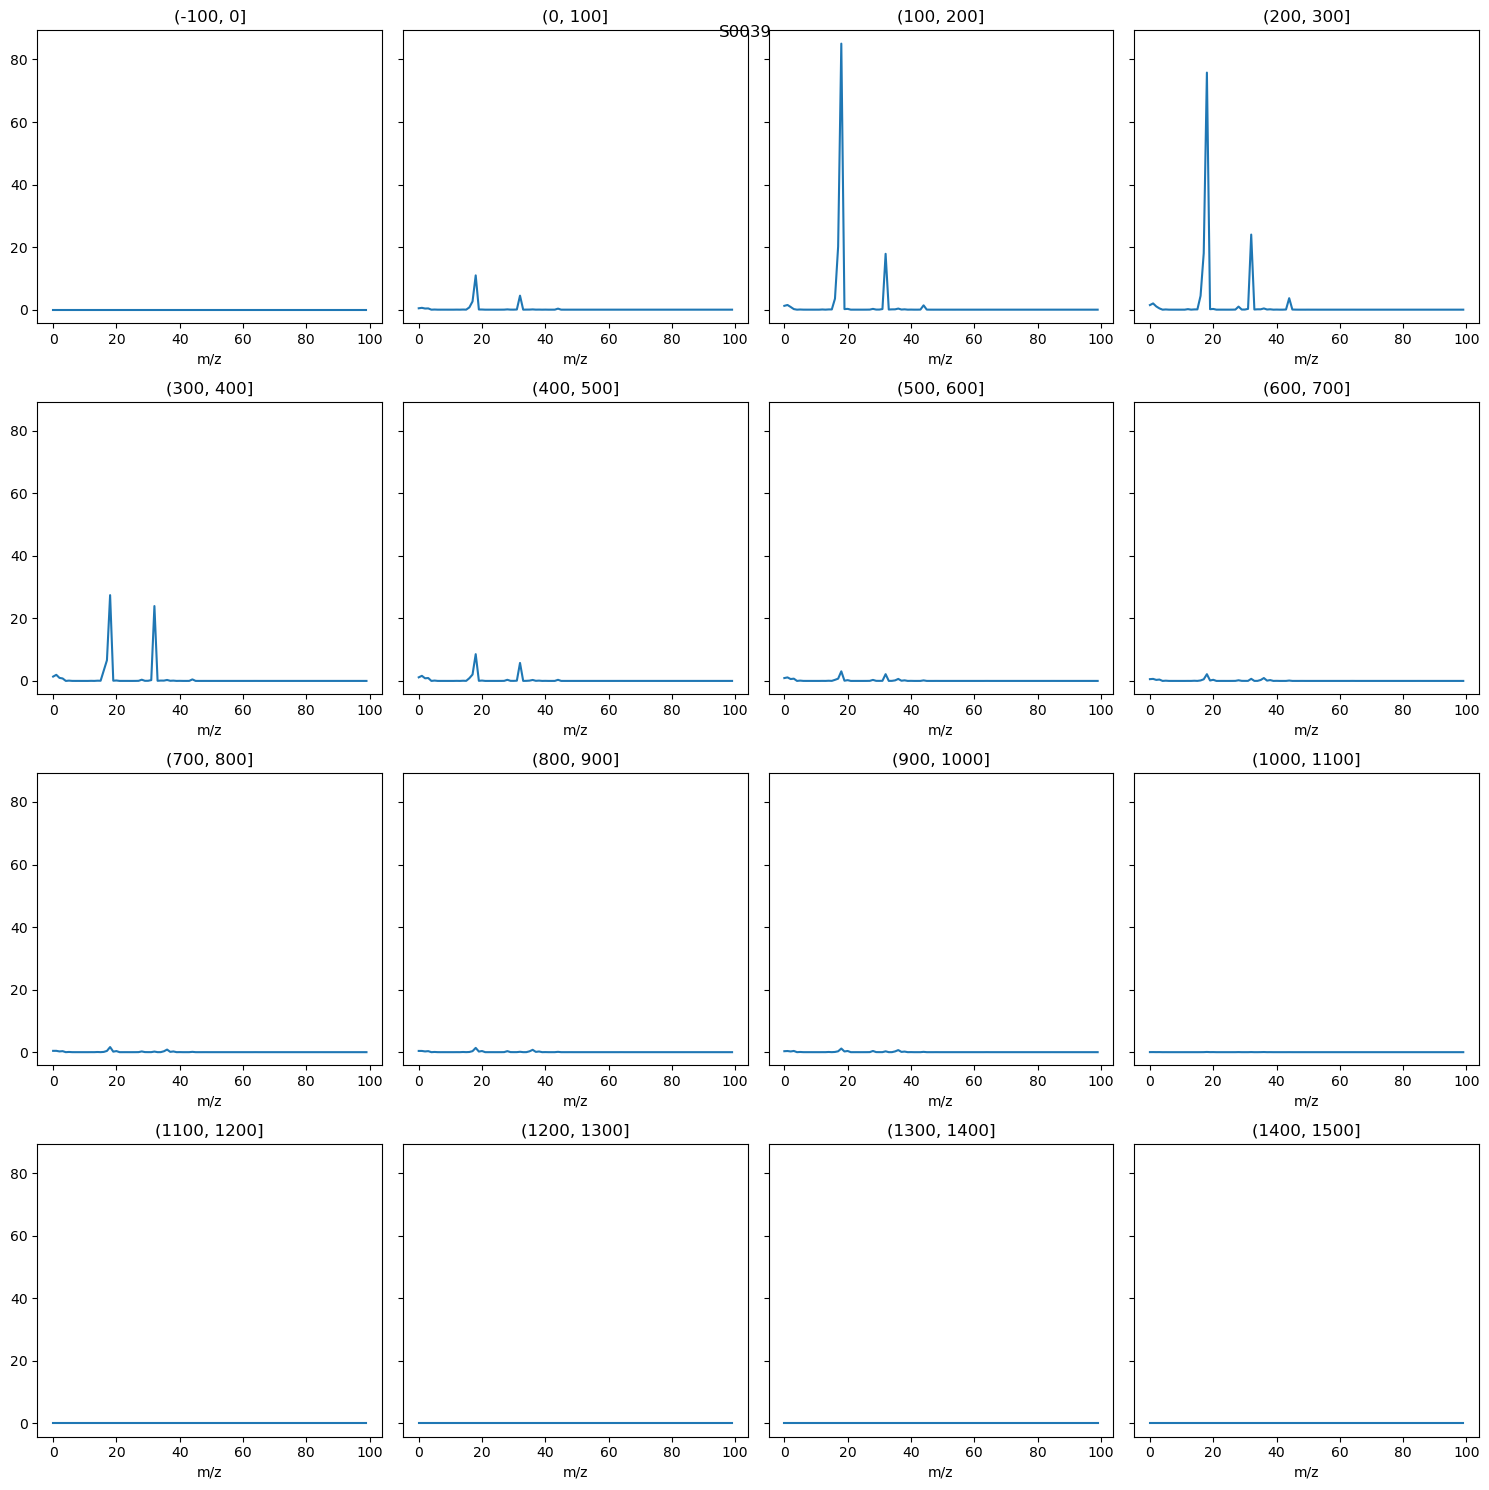

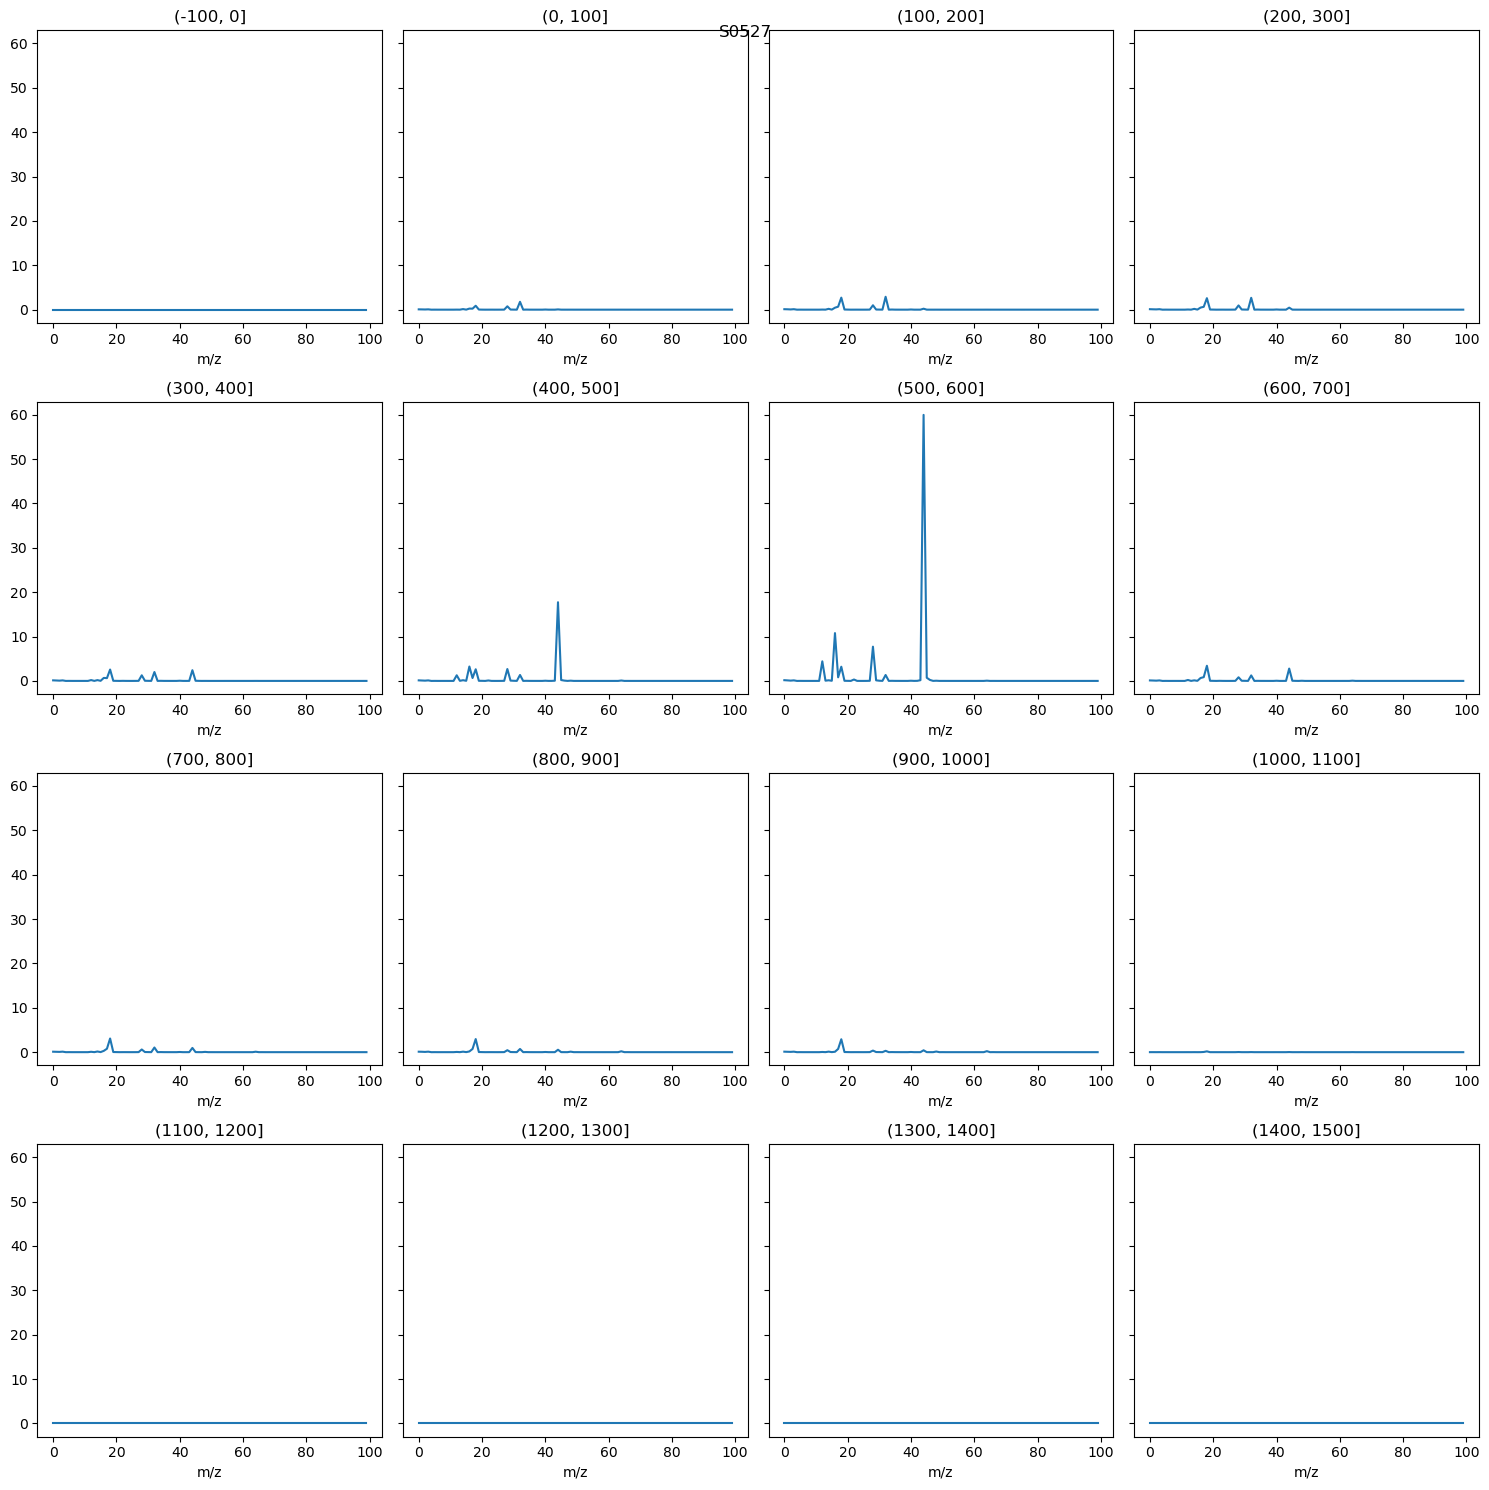

In [46]:
# Create plots of the data in the dataframes above, for various samples

for sample in samples_list[:4]:

    fig, axs = plt.subplots(nrows=4,ncols=4,sharex=False,sharey=True,figsize = (15  ,15))



    for i in range(16):
        
        plt.subplot(4,4,i+1)

        plt.title(str(index_list[i]))



        plt.xlabel('m/z')

        plt.plot(np.linspace(0,99,100),DictAreas[sample].iloc[i])

        plt.tight_layout()

    plt.suptitle(sample+'\n'+'\n')

    plt.show()

In [80]:
len(train_files)

754

In [102]:
# Make dataframe to store all areas under the curve by m/z and temp_bin

import itertools

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
temp = list(itertools.product(temp_bin, [*range(0, 100)]))

temp_df = pd.DataFrame(temp, columns=["temp_bin", "m/z"])

temp_df = temp_df.transpose()

# Rearrange data into dataframe for PCA that keeps bin information
# For each temperature bin, make a dataframe with the m/z values for all samples
# Get each dataframe with sample info

for sample, dataframe in DictAreas.items():

    # Get the list of values in a single row
    df_list = dataframe.values.flatten()

         
    # Add the long row of values to the dataframe made in the previous cell
    temp_df.loc[len(temp_df)] = df_list
    
temp_df

,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
temp_bin,"(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]","(-100, 0]",...,"(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]","(1400, 1500]"
m/z,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.078365,0.576336,0.059872,0.0,0.000967,0.000929,0.000733,0.000733,0.000817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,0.0,0.027547,0.145189,0.040087,0.0,0.000682,0.000318,0.000517,0.000476,0.000593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:


temp_df.iloc[0].values.astype(str)

array(['(-100, 0]', '(-100, 0]', '(-100, 0]', ..., '(1400, 1500]',
       '(1400, 1500]', '(1400, 1500]'], dtype='<U12')

In [ ]:
# Set the index of the array to the first two row

temp_df.columns = pd.MultiIndex.from_arrays([temp_df.iloc[0].values.astype(str), temp_df.iloc[1].values])
temp_df = temp_df.iloc[2:]

temp_df

(-100, 0]                                                         \
           0         1         2         3    4         5         6    
2         0.0       0.0       0.0       0.0  0.0       0.0       0.0   
3         0.0  0.078365  0.576336  0.059872  0.0  0.000967  0.000929   
4         0.0       0.0       0.0       0.0  0.0       0.0       0.0   
5         0.0       0.0       0.0       0.0  0.0       0.0       0.0   
6         0.0       0.0       0.0       0.0  0.0       0.0       0.0   
..        ...       ...       ...       ...  ...       ...       ...   
751       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
752       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
753       0.0  0.027547  0.145189  0.040087  0.0  0.000682  0.000318   
754       0.0       0.0       0.0       0.0  0.0       0.0       0.0   
755       0.0       0.0       0.0       0.0  0.0       0.0       0.0   

                                   ... (1400, 1500]                           \
           7         8         9   ...           90   91   92   93   94   95   
2         0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
3    0.000733  0.000733  0.000817  ...          0.0  0.0  0.0  0.0  0.0  0.0   
4         0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
5         0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
6         0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
..        ...       ...       ...  ...          ...  ...  ...  ...  ...  ...   
751       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
752       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
753  0.000517  0.000476  0.000593  ...          0.0  0.0  0.0  0.0  0.0  0.0   
754       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   
755       0.0       0.0       0.0  ...          0.0  0.0  0.0  0.0  0.0  0.0   

                         
      96   97   98   99  
2    0.0  0.0  0.0  0.0  
3    0.0  0.0  0.0  0.0  
4    0.0  0.0  0.0  0.0  
5    0.0  0.0  0.0  0.0  
6    0.0  0.0  0.0  0.0  
..   ...  ...  ...  ...  
751  0.0  0.0  0.0  0.0  
752  0.0  0.0  0.0  0.0  
753  0.0  0.0  0.0  0.0  
754  0.0  0.0  0.0  0.0  
755  0.0  0.0  0.0  0.0  

[754 rows x 1600 columns]

In [124]:
temp_df[(   '(-100, 0]',  9)]

2           0.0
3      0.000817
4           0.0
5           0.0
6           0.0
         ...   
751         0.0
752         0.0
753    0.000593
754         0.0
755         0.0
Name: ((-100, 0], 9), Length: 754, dtype: object

In [123]:
# Set the index of the array to the first row

temp_df.columns = pd.MultiIndex.from_arrays([temp_df.columns, temp_df.iloc[0].values])
temp_df = temp_df.iloc[2:]

temp_df

NotImplementedError: isna is not defined for MultiIndex

Let's do PCA on each temperature bin in temp_df array to reduce the number of features to train our models. I'll try PCA first on the first 100 columns (first temp bin). Make a plot of the cumulative explained variance to decide how many components to use for PCA.

Text(0, 0.5, 'cumulative explained variance')

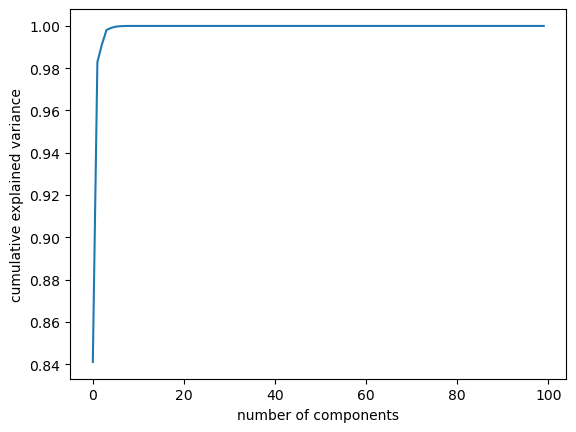

In [ ]:
# import PCA
from sklearn.decomposition import PCA

# Try it on one dataframe
pca_df = temp_df.iloc[1:, :100]

# Fit and make plot of explained variance ratio
principal_components = PCA().fit(pca_df)

# pca = PCA().fit(digits.data)
plt.plot(np.cumsum(principal_components.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


From going through and making plots of a few random dataframes, overall it looks like we can capture most of the data with 3 components. So let's do PCA to 3 components for each dataframe and store that in a csv that can be used for modeling.

<Axes: >

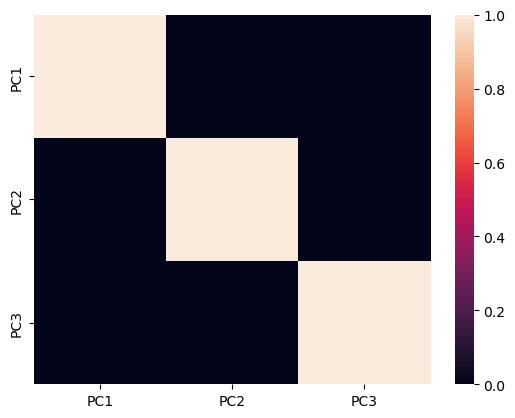

In [ ]:
from sklearn.preprocessing import StandardScaler  # to standardize the features
import seaborn as sns

#Test the PCA with 3 components on the above dataframe
scaler = StandardScaler() 
scaled_data = pd.DataFrame(scaler.fit_transform(pca_df)) #scaling the data

pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
    
sns.heatmap(data_pca.corr())
#data_pca

It looks like there is no correlation between the obtained principal components, so carrying out PCA accomplished our desired objective. Let's do these for each temperature bin (every 100 columns) in the dataframe.

In [ ]:
# Import CSV to write outputs to file for modeling
import csv
# List to hold PCA dataframes
pca_concat_list = []

# Iterate through dataframe
for i in range(0, len(temp_df.columns), 100):
    subset_df = temp_df.iloc[1:, i:i+100]
    #print(subset_df)
    # Standard scale the subset
    scaler = StandardScaler() 
    scaled_df = pd.DataFrame(scaler.fit_transform(subset_df))  

    # Carry out PCA with 3 components
    pca = PCA(n_components = 3)
    pca.fit(scaled_df)
    data_pca = pca.transform(scaled_df)
    data_pca = pd.DataFrame(data_pca)
    pca_concat_list.append(data_pca)

#print(pca_concat_list)
# Concatenate the dataframes
train_df = pd.concat(pca_concat_list, axis=1)
train_df
    
  

,0,1,2,0,1,2,0,1,2,0,...,2,0,1,2,0,1,2,0,1,2
0,-0.621492,0.165280,0.125295,-0.784563,-1.268913,0.147361,-0.850240,-1.674688,0.228735,-0.896297,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
1,2.007919,-3.813076,-0.893565,-0.771116,-1.316065,-0.368455,-0.866575,-1.992731,0.967201,-0.895989,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
2,-0.621492,0.165280,0.125295,-0.757530,-0.833097,1.047529,-0.839254,-1.120552,-0.780532,-0.903256,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
3,-0.621492,0.165280,0.125295,-0.794925,-1.349837,-0.085693,-0.837493,-1.259507,-0.268338,-0.900325,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
4,-0.621492,0.165280,0.125295,-0.782964,-1.322934,-0.275282,-0.785496,-0.772100,-0.888278,-0.830417,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,-0.621492,0.165280,0.125295,-0.162081,0.546671,0.342431,-0.107018,1.277499,-0.871815,-0.180641,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
750,-0.621492,0.165280,0.125295,-0.775474,-1.443004,-0.449175,-0.838226,-1.865213,0.726747,-0.858579,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
751,1.185711,-2.569778,-3.077286,-0.513721,2.316029,7.273461,-0.732185,-0.011605,-0.953857,-0.842814,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15
752,-0.621492,0.165280,0.125295,-0.772646,-1.342700,-0.591755,-0.801092,-1.235581,-0.051681,-0.750540,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.286049e-15,1.370432e-15


In [125]:
# Make dataframe with index as temp_bins so that info doesn't get lost
# and all m/z values
temp = list(itertools.product(temp_bin, [*range(0, 100)]))

temp_df = pd.DataFrame(temp, columns=["temp_bin", "m/z"])

temp_df = temp_df.transpose()

In [ ]:
#